# Sentiment Analysis

## 1.1) Load & Combine Data

In [1]:
import pandas as pd  # for handling dataframes
import re  # for regular expressions
import numpy as np  # for numerical operations
from collections import Counter  # for counting words/n-grams
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS  # stopwords list

# --- Load Data from text files ---
# Each dataset has sentences and labels (0=negative, 1=positive)

df_yelp = pd.read_csv(
    './sentiment labelled sentences/yelp_labelled.txt',  # path to Yelp dataset
    names=['sentence', 'label'],  # column names
    sep='\t',  # tab-separated values
    encoding='utf-8'
)

df_amazon = pd.read_csv(
    './sentiment labelled sentences/amazon_cells_labelled.txt',  # Amazon reviews
    names=['sentence', 'label'],
    sep='\t',
    encoding='utf-8'
)

df_imdb = pd.read_csv(
    './sentiment labelled sentences/imdb_labelled.txt',  # IMDB reviews
    names=['sentence', 'label'],
    sep='\t',
    encoding='utf-8'
)

# Print dataset shapes to see how many rows/examples each has
print("Yelp:", df_yelp.shape)
print("Amazon:", df_amazon.shape)
print("IMDB:", df_imdb.shape)

# --- Combine all datasets into one dataframe ---
df_all = pd.concat([df_yelp, df_amazon, df_imdb], ignore_index=True)
print("Combined:", df_all.shape)  # check total number of examples

# Keep a copy of combined dataset for further processing
df = df_all.copy()


Yelp: (1000, 2)
Amazon: (1000, 2)
IMDB: (748, 2)
Combined: (2748, 2)


## 1.2) Explore Data

In [2]:
# --- Tokenizer ---
# This regex keeps words and contractions like "don't"
_token_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")


def tok(s):
    """Convert a sentence to a list of lowercase tokens/words."""
    if not isinstance(s, str):
        return []
    return _token_re.findall(s.lower())


# --- Label distribution per dataset ---
for name, d in [('Yelp', df_yelp), ('Amazon', df_amazon), ('IMDB', df_imdb)]:
    percent = (d['label']
               .value_counts(normalize=True)  # get percentages
               .sort_index() * 100).round(2)
    print(f"\n{name} label distribution (%):")
    print(percent)

# --- Overview of combined dataset ---
print("\nDataset shape:", df.shape)  # number of rows and columns
print("Missing values:", df.isna().sum().to_dict())  # check for NaNs

# --- Global label distribution ---
counts = df['label'].value_counts().sort_index()  # counts of 0 and 1
pct = (df['label'].value_counts(normalize=True).sort_index() * 100).round(2)  # percentages
print("\nGlobal label distribution:")
print(pd.DataFrame({'count': counts, 'percent': pct}))


# --- Basic text statistics ---
def stats(text):
    """Compute simple statistics for a sentence."""
    s = text if isinstance(text, str) else ""  # handle non-string entries
    t = tok(s)  # tokenize
    n = len(t)  # number of tokens
    return pd.Series({
        'char_len': len(s),  # number of characters
        'word_len': n,  # number of words
        'avg_word_len': (sum(len(x) for x in t) / n) if n else 0.0,  # average word length
        'stop_ratio': sum(x in ENGLISH_STOP_WORDS for x in t) / (n or 1),  # fraction of stopwords
        'ttr': len(set(t)) / (n or 1),  # type-token ratio (vocabulary richness)
    })


# Apply stats to all sentences
df_e = df['sentence'].apply(stats)
# Combine label column with computed stats
df_e = pd.concat([df[['label']], df_e], axis=1)

print("\nOverall descriptors:")
print(df_e.describe().round(3).T)  # summary statistics

print("\nMean descriptors per label:")
print(df_e.groupby('label').mean(numeric_only=True).round(3))  # average per sentiment


# --- N-Gram Extraction ---
def top_ngrams(texts, n=1, k=10, drop_stop=True):
    """
    Extract top-k n-grams from a list of sentences.

    Args:
        texts: list of sentences
        n: size of n-gram (1=unigram, 2=bigram, etc.)
        k: top-k n-grams to return
        drop_stop: whether to remove stopwords
    Returns:
        DataFrame with top-k n-grams and counts
    """
    c = Counter()
    for s in texts:
        tokens = tok(s)
        if drop_stop:
            tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]
        grams = tokens if n == 1 else [
            " ".join(tokens[i:i + n]) for i in range(len(tokens) - n + 1)
        ]
        c.update(grams)
    df_out = pd.DataFrame(c.most_common(k), columns=[f'{n}-gram', 'count'])
    return df_out


print("\nTop Unigrams (all):")
print(top_ngrams(df['sentence'], n=1, k=10))  # top 10 single words

print("\nTop Bigrams (all):")
print(top_ngrams(df['sentence'], n=2, k=10))  # top 10 two-word combinations

# Top n-grams per label
for lbl in sorted(df['label'].unique()):
    print(f"\nTop Unigrams (Label={lbl}):")
    print(top_ngrams(df[df['label'] == lbl]['sentence'], n=1, k=10))

    print(f"\nTop Bigrams (Label={lbl}):")
    print(top_ngrams(df[df['label'] == lbl]['sentence'], n=2, k=10))


# --- Vocabulary Size ---
def vocab_size(texts):
    """Compute the number of unique words in a list of sentences, excluding stopwords."""
    v = set()
    for s in texts:
        v.update([w for w in tok(s) if w not in ENGLISH_STOP_WORDS])
    return len(v)


print("\nTotal vocabulary size (no stopwords):", vocab_size(df['sentence']))

print("\nVocabulary size per label:")
print(df.groupby('label')['sentence'].apply(vocab_size).to_frame('vocab_size'))



Yelp label distribution (%):
label
0    50.0
1    50.0
Name: proportion, dtype: float64

Amazon label distribution (%):
label
0    50.0
1    50.0
Name: proportion, dtype: float64

IMDB label distribution (%):
label
0    48.4
1    51.6
Name: proportion, dtype: float64

Dataset shape: (2748, 2)
Missing values: {'sentence': 0, 'label': 0}

Global label distribution:
       count  percent
label                
0       1362    49.56
1       1386    50.44

Overall descriptors:
               count    mean      std  min     25%     50%     75%     max
label         2748.0   0.504    0.500  0.0   0.000   1.000   1.000     1.0
char_len      2748.0  71.620  204.405  7.0  32.000  55.000  87.000  8041.0
word_len      2748.0  12.896   33.489  0.0   6.000  10.000  16.000  1297.0
avg_word_len  2748.0   4.498    0.974  0.0   3.923   4.364   4.909    13.0
stop_ratio    2748.0   0.494    0.181  0.0   0.417   0.500   0.609     1.0
ttr           2748.0   0.956    0.073  0.0   0.917   1.000   1.000     1.

## 2.1) Text Cleaning (Improved)

In [3]:
import re  # regular expressions for text processing
import html  # for handling HTML entities

# --- Optional: Lemmatization using NLTK ---
use_lemmatize = True
try:
    import nltk
    from nltk.stem import WordNetLemmatizer

    # Check if NLTK data is downloaded
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/omw-1.4')
    _lemmatizer = WordNetLemmatizer()  # create lemmatizer
except Exception:
    # fallback to stemming if NLTK or wordnet not available
    use_lemmatize = False

from nltk.stem import PorterStemmer  # fallback stemmer

_stemmer = PorterStemmer()  # create stemmer instance

# --- Common English contractions ---
# This dictionary maps contractions to their expanded form
# e.g., "don't" -> "do not"
CONTRACTIONS = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he's": "he is", "she's": "she is", "it's": "it is", "i'm": "i am", "i've": "i have",
    "i'd": "i would", "i'll": "i will", "isn't": "is not", "let's": "let us", "mightn't": "might not",
    "mustn't": "must not", "shan't": "shall not", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they're": "they are", "they've": "they have",
    "we're": "we are", "we've": "we have", "we'll": "we will", "weren't": "were not",
    "what's": "what is", "who's": "who is", "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are", "y'all": "you all"
}

# --- Regex patterns for cleaning ---
_url_re = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)  # match URLs
_html_tag_re = re.compile(r"<[^>]+>")  # match HTML tags
_num_re = re.compile(r"\b\d+(?:[.,]\d+)?\b")  # match numbers
_punct_re = re.compile(r"[\.,!?:;\-\(\)\[\]\{\}\"\'`~\/_\\\|@#\$%\^&\*\+=><]+")  # punctuation
_token_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")  # keep words and contractions


# --- Core functions ---

def expand_contractions(text: str) -> str:
    """Expand common English contractions to full words."""
    if not isinstance(text, str):
        return ""  # return empty string if input is not text

    def repl(match):
        return CONTRACTIONS.get(match.group(0).lower(), match.group(0))  # replace contraction

    # Create regex pattern from all contractions keys
    pattern = r"\b(" + "|".join(map(re.escape, CONTRACTIONS.keys())) + r")\b"
    return re.sub(pattern, repl, text, flags=re.IGNORECASE)  # apply replacement


def basic_clean(text: str) -> str:
    """Clean text: remove URLs, HTML tags, numbers, punctuation, lowercase."""
    if not isinstance(text, str):
        return ""
    s = html.unescape(text)  # convert HTML entities to normal text
    s = _url_re.sub(" ", s)  # remove URLs
    s = _html_tag_re.sub(" ", s)  # remove HTML tags
    s = expand_contractions(s)  # expand contractions
    s = _num_re.sub(" ", s)  # remove numbers
    s = _punct_re.sub(" ", s)  # remove punctuation
    s = s.lower()  # convert to lowercase
    s = re.sub(r"\s+", " ", s).strip()  # remove extra spaces
    return s


def tokenize(text: str):
    """Split text into list of words (tokens)."""
    return _token_re.findall(text)


def normalize_tokens(tokens):
    """Convert tokens to base form using lemmatization or stemming."""
    out = []
    for t in tokens:
        if use_lemmatize:
            try:
                out.append(_lemmatizer.lemmatize(t))  # lemmatize word
            except Exception:
                out.append(_stemmer.stem(t))  # fallback to stemming
        else:
            out.append(_stemmer.stem(t))  # stem if lemmatizer not available
    return out


def clean_text_pipeline(text: str, remove_stopwords=False):
    """
    Full text preprocessing pipeline.

    Args:
        text: raw sentence
        remove_stopwords: True to remove common English stopwords
    Returns:
        clean string, list of normalized tokens
    """
    clean_str = basic_clean(text)  # clean text
    tokens = tokenize(clean_str)  # tokenize
    if remove_stopwords:
        tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]  # remove stopwords
    tokens = normalize_tokens(tokens)  # lemmatize or stem
    return clean_str, tokens


# --- Apply cleaning to the dataset ---
# For deep learning, keep stopwords (important for negations like "not good")
df['clean_text'], df['tokens'] = zip(*df['sentence'].map(lambda x: clean_text_pipeline(x, remove_stopwords=False)))

# --- Compute sentence length after cleaning ---
df['len_tokens'] = df['tokens'].apply(len)  # number of tokens per sentence

# --- Quick check of cleaned data ---
print(df[['sentence', 'clean_text', 'label', 'len_tokens']].head())  # show first 5 rows


                                            sentence  \
0                           Wow... Loved this place.   
1                                 Crust is not good.   
2          Not tasty and the texture was just nasty.   
3  Stopped by during the late May bank holiday of...   
4  The selection on the menu was great and so wer...   

                                          clean_text  label  len_tokens  
0                               wow loved this place      1           4  
1                                  crust is not good      0           4  
2           not tasty and the texture was just nasty      0           8  
3  stopped by during the late may bank holiday of...      1          15  
4  the selection on the menu was great and so wer...      1          12  


## 2.2) Exploratory Data Analysis (EDA) (Improved)

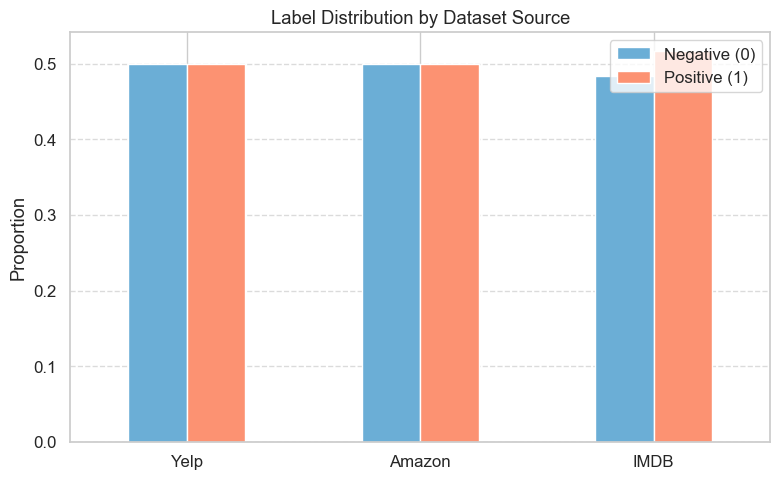

C:\Users\kayam\AppData\Local\Temp\ipykernel_10724\2476994674.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='len_tokens', data=df, palette=['#6baed6','#fc9272'])


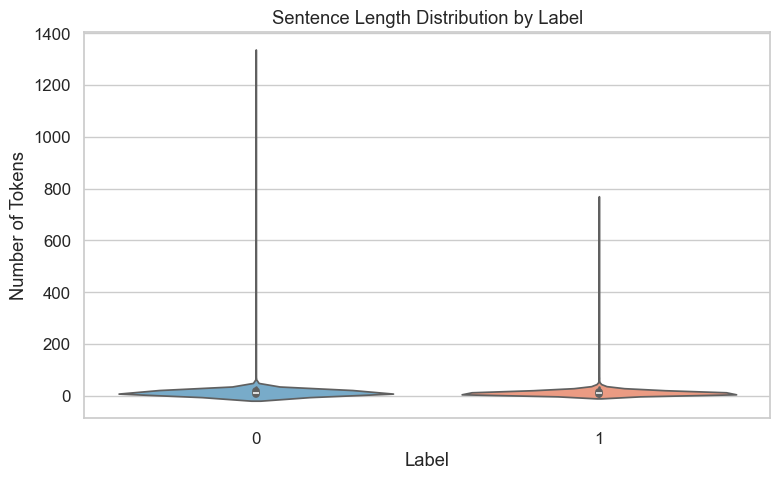

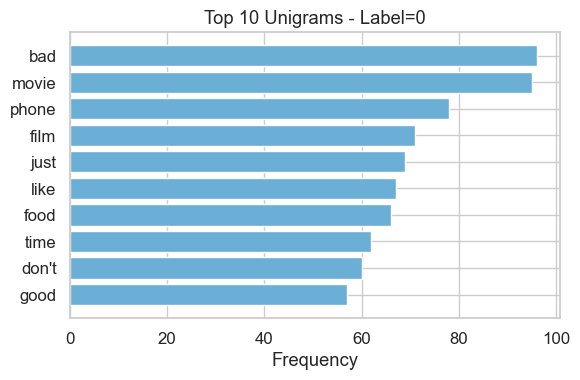

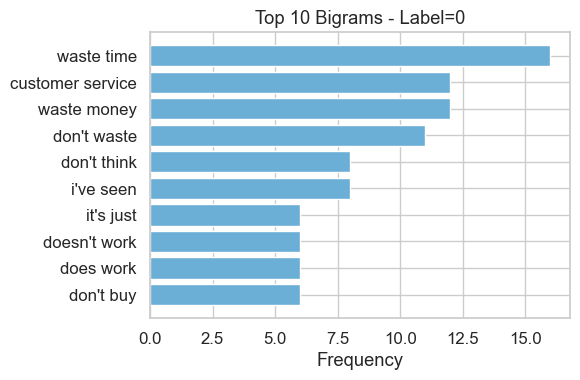

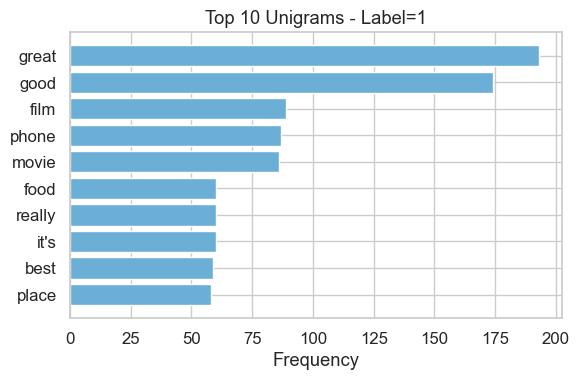

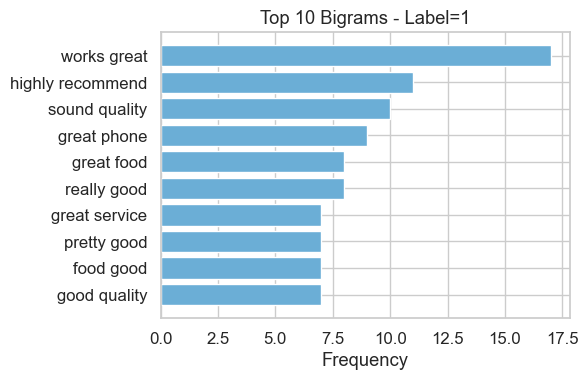

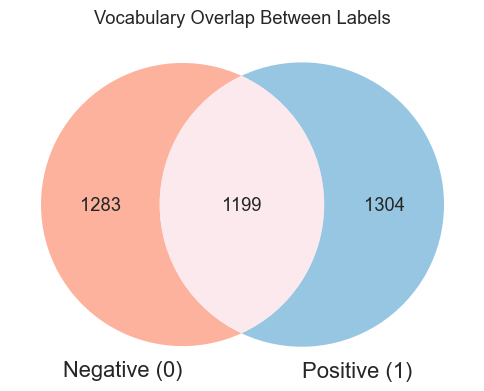

C:\Users\kayam\AppData\Local\Temp\ipykernel_10724\2476994674.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#6baed6','#fc9272'])


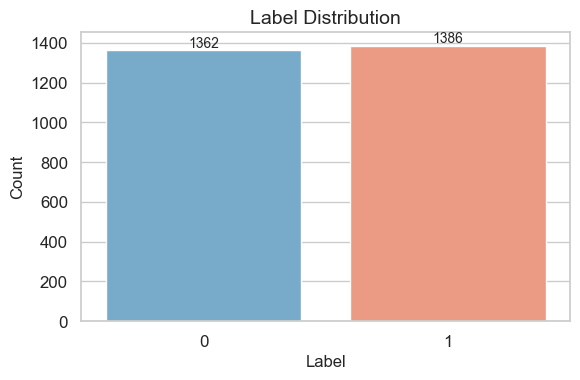

C:\Users\kayam\AppData\Local\Temp\ipykernel_10724\2476994674.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette=[color]*len(words))


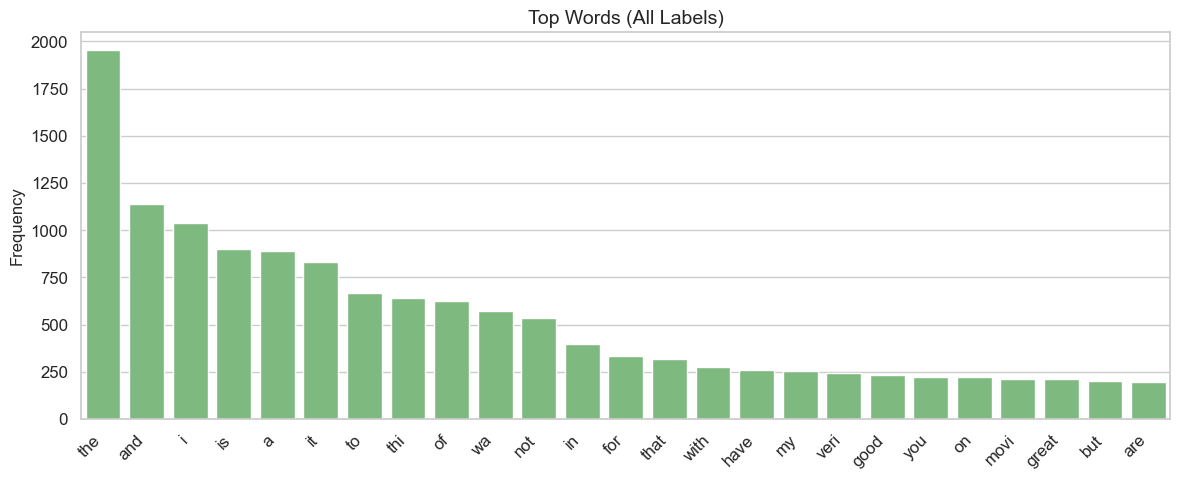

C:\Users\kayam\AppData\Local\Temp\ipykernel_10724\2476994674.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette=[color]*len(words))


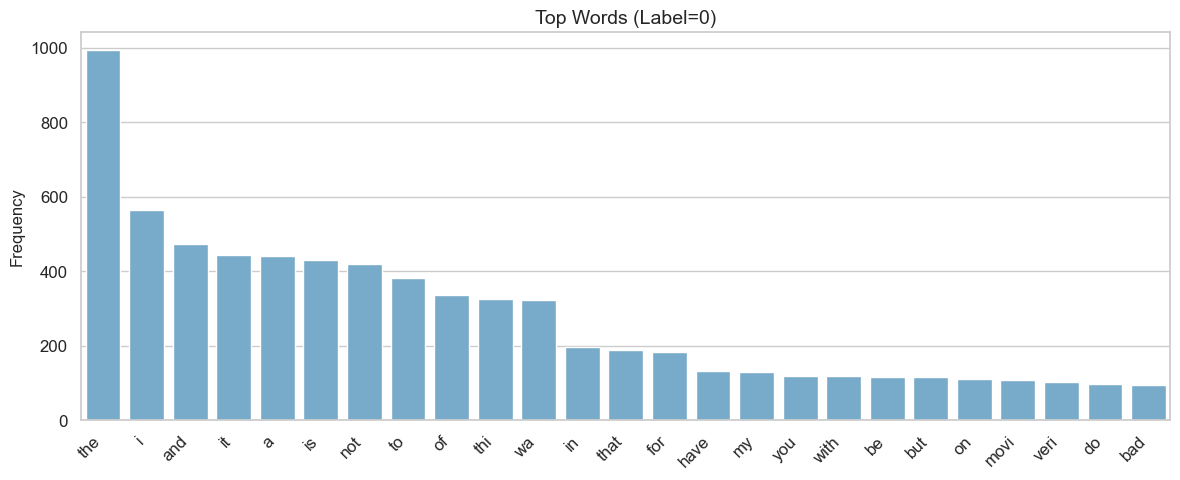

C:\Users\kayam\AppData\Local\Temp\ipykernel_10724\2476994674.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette=[color]*len(words))


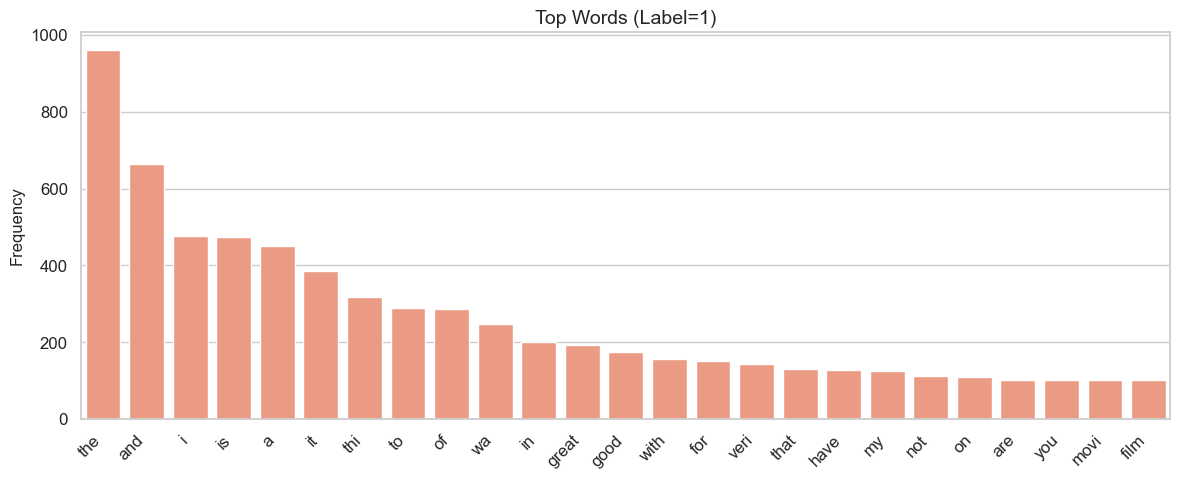

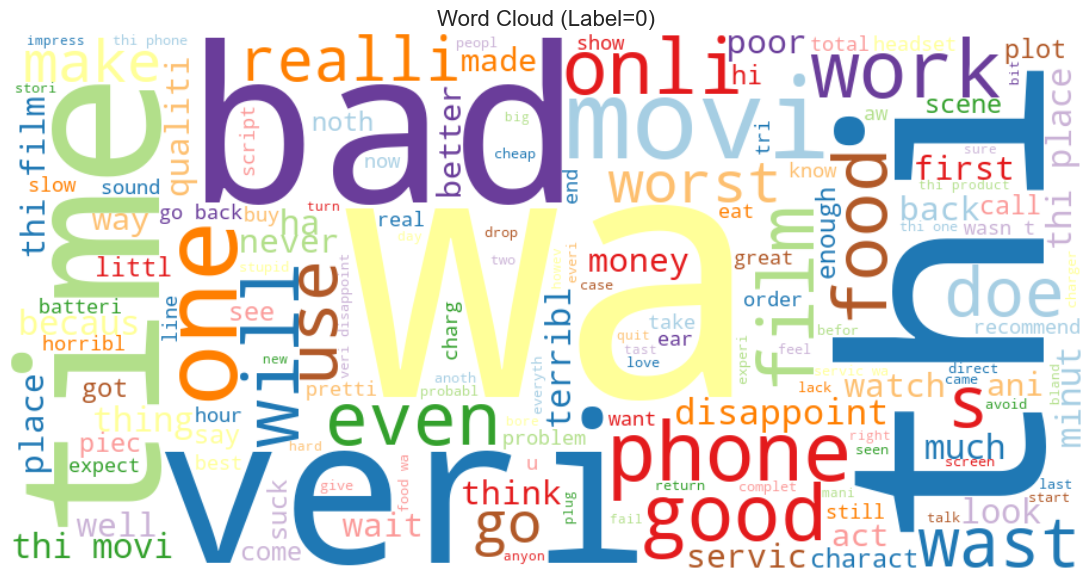

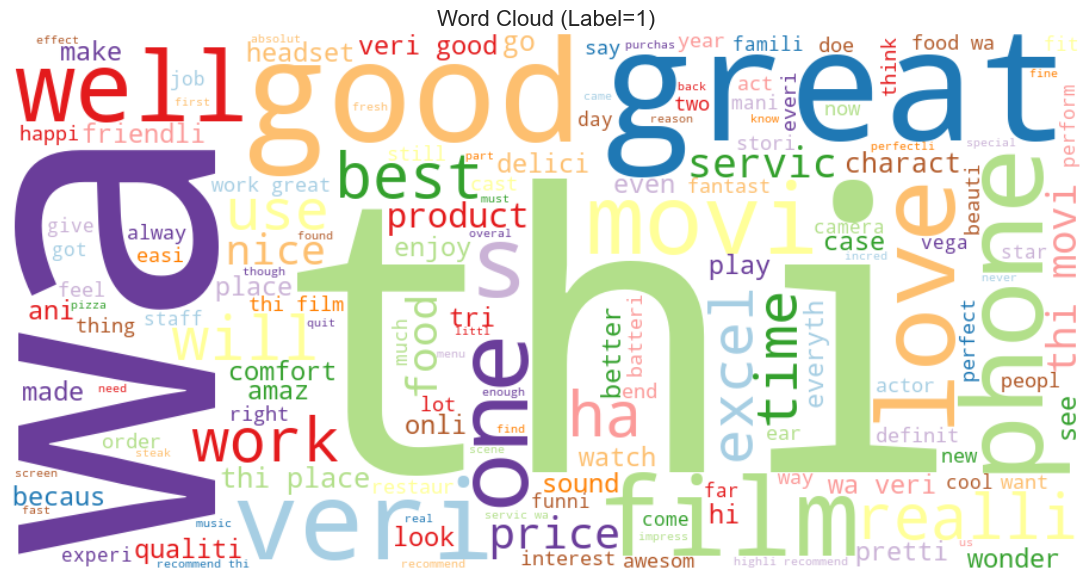

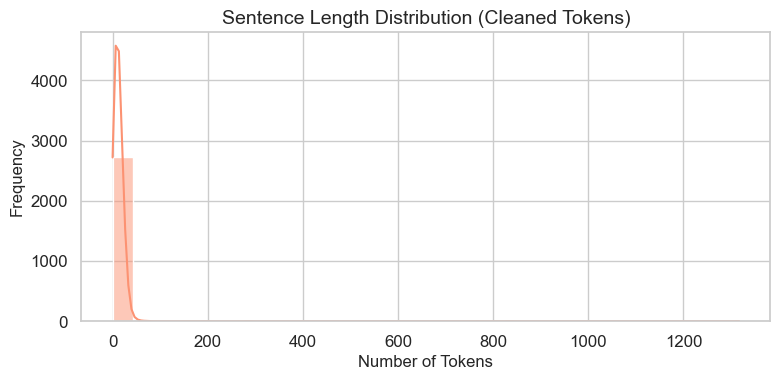

In [4]:
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for nicer statistical plots
from wordcloud import WordCloud  # for creating word clouds

# Set seaborn style for all plots (white background + muted colors + slightly larger font)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- Label distribution by source ---
# Create a DataFrame with proportion of each label per dataset
label_df = pd.DataFrame({
    'Yelp': df_yelp['label'].value_counts(normalize=True).sort_index(),
    'Amazon': df_amazon['label'].value_counts(normalize=True).sort_index(),
    'IMDB': df_imdb['label'].value_counts(normalize=True).sort_index()
}).T  # transpose so that datasets are rows
label_df.columns = ['Negative (0)', 'Positive (1)']  # rename columns

# Plot grouped bar chart
label_df.plot(kind='bar', figsize=(8,5), color=['#6baed6','#fc9272'])
plt.ylabel('Proportion')
plt.title('Label Distribution by Dataset Source')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # horizontal grid lines
plt.tight_layout()
plt.show()

# --- Sentence length distribution by label ---
# Violin plot shows distribution and density of sentence lengths
plt.figure(figsize=(8,5))
sns.violinplot(x='label', y='len_tokens', data=df, palette=['#6baed6','#fc9272'])
plt.title('Sentence Length Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Number of Tokens')
plt.tight_layout()
plt.show()

# --- Top N-grams per label (horizontal barplots) ---
def plot_top_ngrams_bar(texts, label_name, n=1, top_k=10, drop_stop=True):
    """Plot top-k unigrams or bigrams for a given label."""
    c = Counter()  # count occurrences
    for s in texts:
        tokens = tok(s)  # tokenize sentence
        if drop_stop:
            tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]  # remove stopwords
        grams = tokens if n == 1 else [
            " ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)  # create n-grams
        ]
        c.update(grams)  # update counts
    top = c.most_common(top_k)  # get top k n-grams
    if not top:
        return
    words, counts = zip(*top)
    plt.figure(figsize=(6,4))
    plt.barh(words[::-1], counts[::-1], color='#6baed6')  # horizontal bar plot
    plt.title(f'Top {top_k} {"Unigrams" if n==1 else "Bigrams"} - Label={label_name}')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot top unigrams and bigrams for each label
for lbl in sorted(df['label'].unique()):
    plot_top_ngrams_bar(df[df['label']==lbl]['sentence'], label_name=lbl, n=1, top_k=10)
    plot_top_ngrams_bar(df[df['label']==lbl]['sentence'], label_name=lbl, n=2, top_k=10)

# --- Vocabulary overlap (Venn diagram) ---
try:
    from matplotlib_venn import venn2

    # Get unique tokens per label (exclude stopwords)
    tokens_neg = set([t for toks in df[df['label']==0]['tokens'] for t in toks if t not in ENGLISH_STOP_WORDS])
    tokens_pos = set([t for toks in df[df['label']==1]['tokens'] for t in toks if t not in ENGLISH_STOP_WORDS])

    plt.figure(figsize=(6,6))
    venn2([tokens_neg, tokens_pos], set_labels=('Negative (0)', 'Positive (1)'),
          set_colors=('#fc9272','#6baed6'), alpha=0.7)
    plt.title('Vocabulary Overlap Between Labels')
    plt.show()
except Exception as e:
    print("Venn diagram could not be plotted:", e)

# --- Label distribution (overall) ---
label_counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#6baed6','#fc9272'])
plt.title('Label Distribution', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
# Add counts on top of bars for clarity
for i, v in enumerate(label_counts.values):
    plt.text(i, v + max(label_counts.values)*0.01, str(v), ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# --- Word frequency plots ---
def plot_top_words(token_series, title, top_k=20, color="#74c476"):
    """Plot top-K words from tokenized series."""
    freq = Counter([t for tokens in token_series for t in tokens])  # count all tokens
    top = freq.most_common(top_k)
    if top:
        words, counts = zip(*top)
        plt.figure(figsize=(12,5))
        sns.barplot(x=list(words), y=list(counts), palette=[color]*len(words))
        plt.xticks(rotation=45, ha='right')
        plt.title(title, fontsize=14)
        plt.ylabel('Frequency', fontsize=12)
        plt.xlabel('')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No tokens available for {title}")

# Plot top words for all labels combined
plot_top_words(df['tokens'], 'Top Words (All Labels)', top_k=25, color="#74c476")

# Plot top words per label
label_colors = ['#6baed6','#fc9272']
for i, lbl in enumerate(sorted(df['label'].unique())):
    plot_top_words(df.loc[df['label']==lbl, 'tokens'], f'Top Words (Label={lbl})', top_k=25, color=label_colors[i])

# --- Word clouds ---
for i, lbl in enumerate(sorted(df['label'].unique())):
    # Combine all tokens for label into single string
    text_blob = " ".join([" ".join(toks) for toks in df.loc[df['label']==lbl, 'tokens']])
    if text_blob.strip():
        wc = WordCloud(
            width=900, height=450,
            background_color='white',
            colormap='Paired',  # color palette
            max_words=150,
            contour_color='black',
            contour_width=1
        ).generate(text_blob)
        plt.figure(figsize=(12,6))
        plt.imshow(wc, interpolation='bilinear')  # render word cloud
        plt.axis('off')
        plt.title(f'Word Cloud (Label={lbl})', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No tokens for label {lbl} to build word cloud")

# --- Sentence length histogram ---
plt.figure(figsize=(8,4))
sns.histplot(df['len_tokens'], bins=30, kde=True, color='#fc9272')  # histogram + KDE
plt.title('Sentence Length Distribution (Cleaned Tokens)', fontsize=14)
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


## 2.3) Train/Validation/Test Split (70/15/15) with CSV Save

In [5]:
from sklearn.model_selection import train_test_split  # for splitting data into train/val/test

# Features (X) include original sentence, cleaned text, and token list
X = df[['sentence','clean_text','tokens']].copy()
# Labels (y) are the sentiment values (0 or 1), ensure integer type
y = df['label'].astype(int)

# --- First split: 70% train, 30% temporary (to be split into val/test) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42  # stratify ensures label distribution is preserved
)

# --- Second split: split temp into 50% validation, 50% test (15% each overall) ---
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# --- Print shapes to confirm sizes ---
print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

import os

# Ensure that a folder exists to save CSVs
os.makedirs('./data/', exist_ok=True)

# --- Save train/val/test splits as CSV for reproducibility ---
X_train.join(y_train).to_csv('./data/train_split.csv', index=False)  # combine features and labels
X_val.join(y_val).to_csv('./data/val_split.csv', index=False)
X_test.join(y_test).to_csv('./data/test_split.csv', index=False)
print("Train/Val/Test splits saved to ./data/")


Shapes:
Train: (1923, 3) (1923,)
Validation: (412, 3) (412,)
Test: (413, 3) (413,)
Train/Val/Test splits saved to ./data/


## 3.1 TF-IDF features for classical ML

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer  # to convert text to numerical features

# --- Custom stopwords list: remove default stopwords but keep negations (important for sentiment) ---
negations = {"not", "no", "never"}
custom_stopwords = list(ENGLISH_STOP_WORDS.difference(negations))

# Hyperparameters for TF-IDF
max_features = 5000  # maximum number of features to keep
ngram_range = (1, 2)  # include unigrams and bigrams

# Initialize TF-IDF vectorizer with custom settings
tfidf_vectorizer = TfidfVectorizer(
    max_features=max_features,
    ngram_range=ngram_range,
    stop_words=custom_stopwords
)

# Convert train/val/test cleaned text to string type
X_train_text = X_train['clean_text'].astype(str)
X_val_text   = X_val['clean_text'].astype(str)
X_test_text  = X_test['clean_text'].astype(str)

# Fit TF-IDF on training data, then transform val/test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf   = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_text)

# Print shapes to confirm number of features and samples
print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Val:  ", X_val_tfidf.shape)
print("Test: ", X_test_tfidf.shape)

import joblib
# Ensure folder exists to save trained models
os.makedirs('./models/', exist_ok=True)

# Save the fitted TF-IDF vectorizer for later use
joblib.dump(tfidf_vectorizer, './models/tfidf_vectorizer.pkl')
print("TF-IDF vectorizer saved to ./models/tfidf_vectorizer.pkl")


TF-IDF shapes:
Train: (1923, 5000)
Val:   (412, 5000)
Test:  (413, 5000)
TF-IDF vectorizer saved to ./models/tfidf_vectorizer.pkl


## 3.2 Tokenization and Padding for Deep Learning Model

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Hyperparameters for deep learning ---
max_words = 10000  # maximum number of words to keep in tokenizer (top most frequent)
max_len = 100      # maximum sequence length for padding/truncating

# Convert token lists back to strings because Keras tokenizer expects raw text
X_train_text_dl = X_train['tokens'].apply(lambda toks: " ".join(toks))
X_val_text_dl   = X_val['tokens'].apply(lambda toks: " ".join(toks))
X_test_text_dl  = X_test['tokens'].apply(lambda toks: " ".join(toks))

# Initialize tokenizer, with special token for out-of-vocabulary words
tokenizer_dl = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer_dl.fit_on_texts(X_train_text_dl)  # fit tokenizer only on training data

# Convert text to sequences of integers
X_train_seq_dl = tokenizer_dl.texts_to_sequences(X_train_text_dl)
X_val_seq_dl   = tokenizer_dl.texts_to_sequences(X_val_text_dl)
X_test_seq_dl  = tokenizer_dl.texts_to_sequences(X_test_text_dl)

# Pad sequences to the same length for model input
# 'post' padding/truncating means extra zeros or truncation occur at the end
X_train_pad_dl = pad_sequences(X_train_seq_dl, maxlen=max_len, padding='post', truncating='post')
X_val_pad_dl   = pad_sequences(X_val_seq_dl,   maxlen=max_len, padding='post', truncating='post')
X_test_pad_dl  = pad_sequences(X_test_seq_dl,  maxlen=max_len, padding='post', truncating='post')

# Print shapes to confirm
print("Padded sequence shapes (DL):")
print("Train:", X_train_pad_dl.shape)
print("Val:  ", X_val_pad_dl.shape)
print("Test: ", X_test_pad_dl.shape)

# Save tokenizer information for embedding layers or future preprocessing
word_index_dl = tokenizer_dl.word_index  # dictionary mapping word -> index
print("Vocabulary size (DL):", len(word_index_dl))

# Save tokenizer object for reuse
joblib.dump(tokenizer_dl, './models/tokenizer_dl.pkl')
print("Tokenizer saved to ./models/tokenizer_dl.pkl")


Padded sequence shapes (DL):
Train: (1923, 100)
Val:   (412, 100)
Test:  (413, 100)
Vocabulary size (DL): 3390
Tokenizer saved to ./models/tokenizer_dl.pkl


## 4.1 Classical Model: Logistic Regression with TF-IDF (Improved, Namespaced)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score,
                             precision_recall_curve, auc)
import seaborn as sns

# --- Use pre-defined train/val/test labels for classical ML ---
y_train_cls = y_train
y_val_cls   = y_val
y_test_cls  = y_test

# --- Naive Bayes model: hyperparameter grid search ---
nb_params = {'alpha': [0.1, 0.5, 1.0, 2.0]}  # smoothing parameter
nb_grid_cls = GridSearchCV(MultinomialNB(), param_grid=nb_params, cv=5,
                           scoring='accuracy', n_jobs=-1)  # 5-fold CV
nb_grid_cls.fit(X_train_tfidf, y_train_cls)  # fit grid search on training TF-IDF features

# Print best parameters and CV accuracy for Naive Bayes
print("Best Naive Bayes params:", nb_grid_cls.best_params_)
print("Best CV accuracy (NB):", nb_grid_cls.best_score_)

# --- Logistic Regression model: hyperparameter grid search ---
log_params = {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}  # C: regularization strength
log_grid_cls = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=log_params,
                            cv=5, scoring='accuracy', n_jobs=-1)
log_grid_cls.fit(X_train_tfidf, y_train_cls)

# Print best parameters and CV accuracy for Logistic Regression
print("Best Logistic Regression params:", log_grid_cls.best_params_)
print("Best CV accuracy (LogReg):", log_grid_cls.best_score_)

# --- Select the better model based on CV accuracy ---
if log_grid_cls.best_score_ >= nb_grid_cls.best_score_:
    best_model_cls = log_grid_cls.best_estimator_
    print("Selected model: Logistic Regression")
else:
    best_model_cls = nb_grid_cls.best_estimator_
    print("Selected model: Naive Bayes")


Best Naive Bayes params: {'alpha': 2.0}
Best CV accuracy (NB): 0.8211038961038961
Best Logistic Regression params: {'C': 1, 'solver': 'lbfgs'}
Best CV accuracy (LogReg): 0.8190219155844156
Selected model: Naive Bayes


## 4.2 Deep Learning Model: BiLSTM (Improved, Light Hyperparameter Search)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# -----------------------------
# Reproducibility: ensure consistent results
# -----------------------------
np.random.seed(42)        # for numpy operations
tf.random.set_seed(42)    # for TensorFlow operations

# -----------------------------
# Hyperparameter options (light search to save time)
# -----------------------------
embedding_dims_dl = [50, 100]       # size of word embeddings (2 options)
lstm_units_list_dl = [32]           # number of LSTM units (1 option to reduce load)
dropout_rates_dl = [0.3]            # dropout rate after dense layer
spatial_dropouts_dl = [0.2]         # spatial dropout after embedding layer
batch_size_dl = 64                   # number of samples per batch
epochs_dl = 12                        # max epochs for training (reduce for speed)

# -----------------------------
# Labels as numpy arrays (required by Keras)
# -----------------------------
y_train_dl = np.array(y_train)
y_val_dl = np.array(y_val)
y_test_dl = np.array(y_test)

# -----------------------------
# Vocabulary size: limited by max_words and tokenizer
# -----------------------------
vocab_size_dl = min(max_words, len(word_index_dl) + 1)

# Variables to track best model during hyperparameter search
best_val_acc_dl = 0.0
best_model_dl = None
best_params_dl = {}

# -----------------------------
# Light hyperparameter search: nested loops
# -----------------------------
for embedding_dim_dl in embedding_dims_dl:
    for lstm_units_dl in lstm_units_list_dl:
        for dropout_rate_dl in dropout_rates_dl:
            for spatial_dropout_dl in spatial_dropouts_dl:

                # Print current hyperparameters
                print(
                    f"\nTraining BiLSTM (DL) with emb={embedding_dim_dl}, "
                    f"lstm={lstm_units_dl}, dropout={dropout_rate_dl}, spatial={spatial_dropout_dl}"
                )

                # -----------------------------
                # Build BiLSTM model
                # -----------------------------
                model_dl = Sequential([
                    # Embedding layer converts integer sequences to dense vectors
                    Embedding(
                        input_dim=vocab_size_dl,
                        output_dim=embedding_dim_dl,
                        input_length=max_len
                    ),
                    # SpatialDropout1D drops entire embedding dimensions to reduce overfitting
                    SpatialDropout1D(spatial_dropout_dl),
                    # Bidirectional LSTM layer
                    Bidirectional(LSTM(
                        lstm_units_dl,
                        return_sequences=False,     # last output only
                        dropout=0.3,               # dropout on input connections
                        recurrent_dropout=0.3,     # dropout on recurrent connections
                        kernel_regularizer=l2(1e-4),       # L2 regularization on weights
                        recurrent_regularizer=l2(1e-4)     # L2 regularization on recurrent weights
                    )),
                    # Dense hidden layer
                    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
                    Dropout(dropout_rate_dl),        # dropout for regularization
                    # Output layer for binary classification
                    Dense(1, activation='sigmoid')
                ])

                # -----------------------------
                # Compile model
                # -----------------------------
                model_dl.compile(
                    loss='binary_crossentropy',  # suitable for binary classification
                    optimizer='adam',            # adaptive optimizer
                    metrics=['accuracy']         # track accuracy during training
                )

                # -----------------------------
                # Early stopping: stop if no improvement in validation loss
                # -----------------------------
                early_stop_dl = EarlyStopping(
                    monitor='val_loss',          # monitor validation loss
                    patience=2,                  # wait for 2 epochs before stopping
                    restore_best_weights=True    # keep best weights
                )

                # -----------------------------
                # Train model
                # -----------------------------
                history_dl = model_dl.fit(
                    X_train_pad_dl, y_train_dl,
                    validation_data=(X_val_pad_dl, y_val_dl),
                    epochs=epochs_dl,
                    batch_size=batch_size_dl,
                    callbacks=[early_stop_dl],  # apply early stopping
                    verbose=0                   # silent output
                )

                # -----------------------------
                # Track maximum validation accuracy
                # -----------------------------
                val_acc_dl = max(history_dl.history['val_accuracy'])
                print(f"Max val accuracy (DL): {val_acc_dl:.3f}")

                # -----------------------------
                # Keep best model and hyperparameters
                # -----------------------------
                if val_acc_dl > best_val_acc_dl:
                    best_val_acc_dl = val_acc_dl
                    best_model_dl = model_dl
                    best_params_dl = {
                        'embedding_dim': embedding_dim_dl,
                        'lstm_units': lstm_units_dl,
                        'dropout_rate': dropout_rate_dl,
                        'spatial_dropout': spatial_dropout_dl
                    }

# -----------------------------
# Print best hyperparameters and validation accuracy
# -----------------------------
print("\nBest hyperparameters found for DL model:")
print(best_params_dl)
print(f"Best Validation Accuracy (DL): {best_val_acc_dl:.3f}")

# -----------------------------
# Save best model to disk
# -----------------------------
os.makedirs('./models/', exist_ok=True)  # ensure folder exists
best_model_dl.save('./models/bilstm_model_best_dl.keras')
print("Best BiLSTM DL model saved to ./models/bilstm_model_best_dl.keras")



Training BiLSTM (DL) with emb=50, lstm=32, dropout=0.3, spatial=0.2


C:\Users\kayam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Max val accuracy (DL): 0.833

Training BiLSTM (DL) with emb=100, lstm=32, dropout=0.3, spatial=0.2
Max val accuracy (DL): 0.825

Best hyperparameters found for DL model:
{'embedding_dim': 50, 'lstm_units': 32, 'dropout_rate': 0.3, 'spatial_dropout': 0.2}
Best Validation Accuracy (DL): 0.833
Best BiLSTM DL model saved to ./models/bilstm_model_best_dl.keras


## 5.1 Plots - Classical Machine Learning Model

Validation classification report CLASSICAL:
              precision    recall  f1-score   support

           0      0.782     0.828     0.805       204
           1      0.821     0.774     0.797       208

    accuracy                          0.801       412
   macro avg      0.802     0.801     0.801       412
weighted avg      0.802     0.801     0.801       412

Test classification report CLASSICAL:
              precision    recall  f1-score   support

           0      0.839     0.761     0.798       205
           1      0.784     0.856     0.818       208

    accuracy                          0.809       413
   macro avg      0.811     0.808     0.808       413
weighted avg      0.811     0.809     0.808       413

Test Accuracy (Classical ML): 0.809


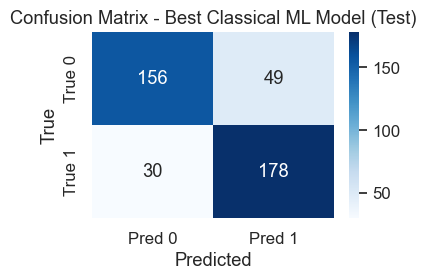

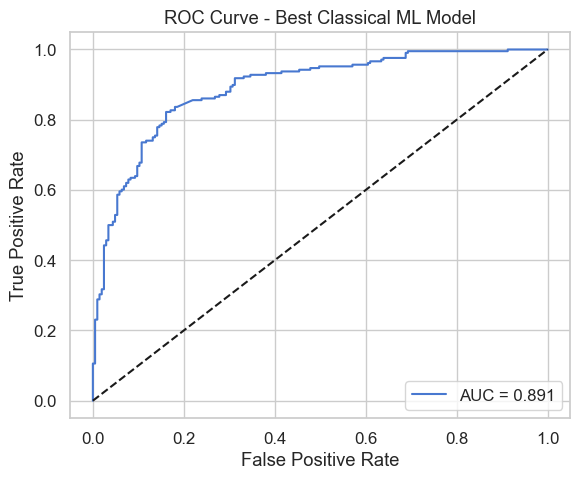

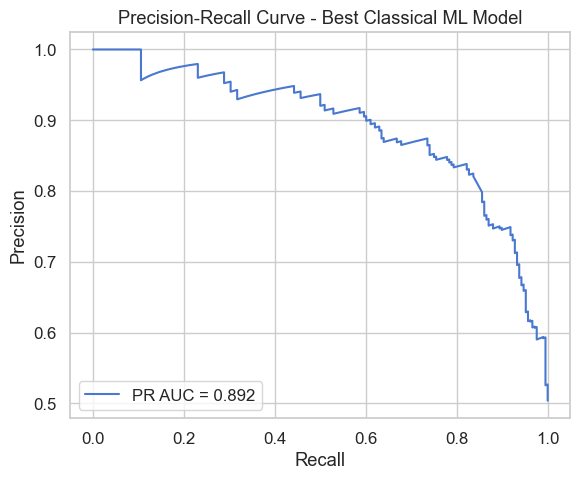

In [10]:
# --- Evaluate on validation set ---
# Predict labels on validation set using the best classical ML model
y_val_pred_cls = best_model_cls.predict(X_val_tfidf)
print("Validation classification report CLASSICAL:")
# Print detailed metrics: precision, recall, f1-score for each class
print(classification_report(y_val_cls, y_val_pred_cls, digits=3))

# --- Evaluate on test set ---
# Predict labels on the test set
y_test_pred_cls = best_model_cls.predict(X_test_tfidf)
print("Test classification report CLASSICAL:")
# Show metrics on test set
print(classification_report(y_test_cls, y_test_pred_cls, digits=3))

# Compute overall test accuracy
test_acc_cls = accuracy_score(y_test_cls, y_test_pred_cls)
print(f"Test Accuracy (Classical ML): {test_acc_cls:.3f}")

# --- Confusion Matrix ---
# Confusion matrix: shows True vs Predicted counts
cm_cls = confusion_matrix(y_test_cls, y_test_pred_cls)
plt.figure(figsize=(4,3))
sns.heatmap(cm_cls, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix - Best Classical ML Model (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# --- ROC and PR Curves ---
# Get probability estimates for positive class
y_test_proba_cls = best_model_cls.predict_proba(X_test_tfidf)[:,1]

# ROC Curve
fpr_cls, tpr_cls, _ = roc_curve(y_test_cls, y_test_proba_cls)
roc_auc_cls = roc_auc_score(y_test_cls, y_test_proba_cls)

plt.figure(figsize=(6,5))
plt.plot(fpr_cls, tpr_cls, label=f'AUC = {roc_auc_cls:.3f}')
plt.plot([0,1], [0,1], 'k--')  # random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Classical ML Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision_cls, recall_cls, _ = precision_recall_curve(y_test_cls, y_test_proba_cls)
pr_auc_cls = auc(recall_cls, precision_cls)

plt.figure(figsize=(6,5))
plt.plot(recall_cls, precision_cls, label=f'PR AUC = {pr_auc_cls:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Classical ML Model')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Top TF-IDF Features (Logistic Regression only) ---
# Only applicable if the model has coefficients (like Logistic Regression)
if hasattr(best_model_cls, 'coef_'):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    coefs_cls = best_model_cls.coef_[0]
    # Top 10 positive features (most indicative of positive sentiment)
    top_pos_idx_cls = coefs_cls.argsort()[-10:][::-1]
    # Top 10 negative features (most indicative of negative sentiment)
    top_neg_idx_cls = coefs_cls.argsort()[:10]

    print("\nTop 10 Positive Features (words indicating positive sentiment):")
    for i in top_pos_idx_cls:
        print(f"{feature_names[i]}: {coefs_cls[i]:.3f}")

    print("\nTop 10 Negative Features (words indicating negative sentiment):")
    for i in top_neg_idx_cls:
        print(f"{feature_names[i]}: {coefs_cls[i]:.3f}")


## 5.2 Plot Training Curves (DL)

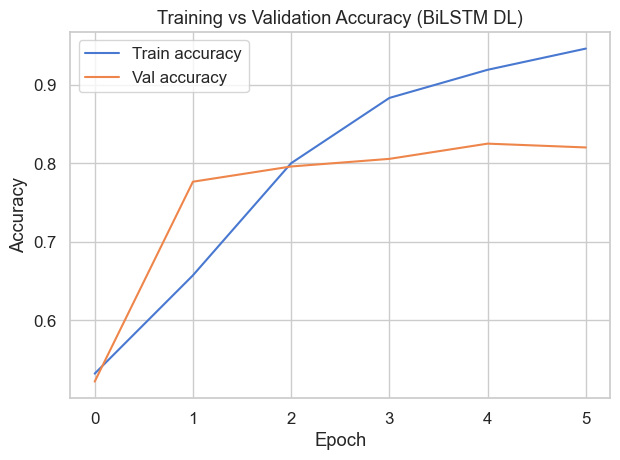

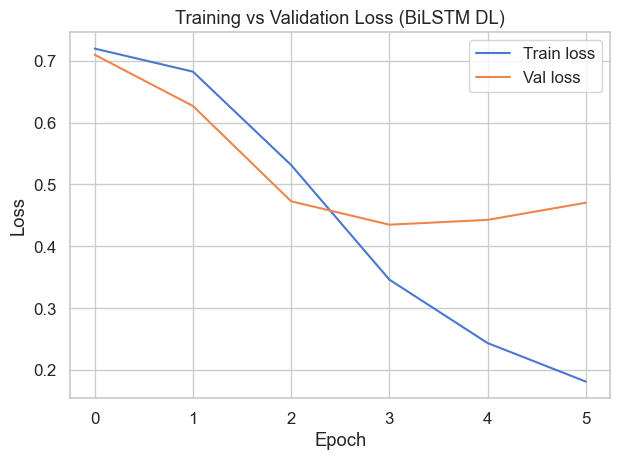

In [11]:
# Accuracy Curve
# Plot training and validation accuracy over epochs for BiLSTM model
plt.figure()
plt.plot(history_dl.history['accuracy'], label='Train accuracy')
plt.plot(history_dl.history['val_accuracy'], label='Val accuracy')
plt.title('Training vs Validation Accuracy (BiLSTM DL)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss Curve
# Plot training and validation loss over epochs for BiLSTM model
plt.figure()
plt.plot(history_dl.history['loss'], label='Train loss')
plt.plot(history_dl.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss (BiLSTM DL)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 5.3 Evaluation on Test Set (DL)

Test Loss (BiLSTM DL): 0.452
Test Accuracy (BiLSTM DL): 0.804
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step

Classification report (BiLSTM DL):
              precision    recall  f1-score   support

           0      0.816     0.780     0.798       205
           1      0.793     0.827     0.809       208

    accuracy                          0.804       413
   macro avg      0.804     0.804     0.804       413
weighted avg      0.804     0.804     0.804       413



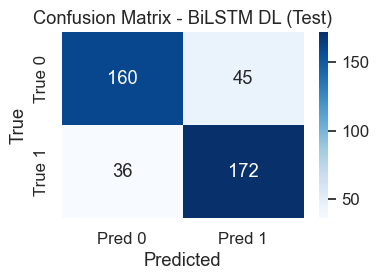

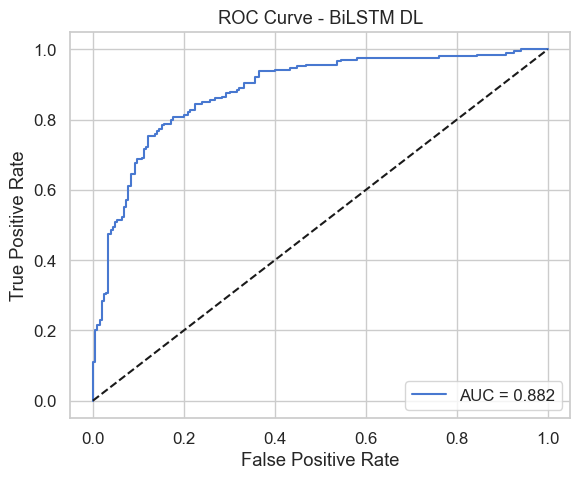

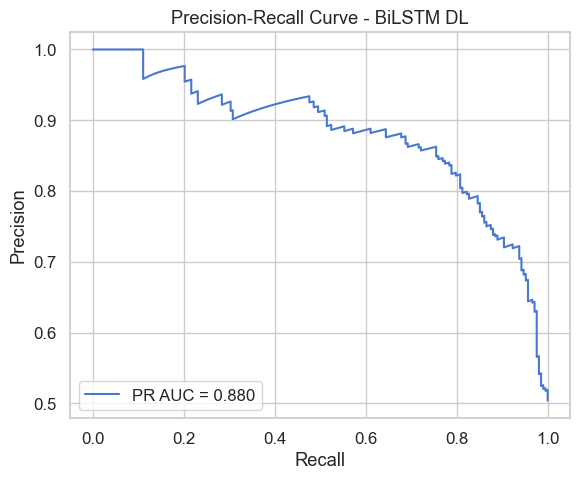


Top 10 influential tokens (BiLSTM DL, L2 norm):
great: 1.054
not: 0.839
disappoint: 0.749
excel: 0.717
love: 0.699
bad: 0.688
nice: 0.686
wast: 0.677
worst: 0.640
good: 0.640

BiLSTM DL Test Accuracy: 0.804
BiLSTM DL Precision: 0.793
BiLSTM DL Recall: 0.827
BiLSTM DL F1-score: 0.809


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Evaluate overall test loss and accuracy for BiLSTM DL model ---
test_loss_dl, test_acc_dl = best_model_dl.evaluate(X_test_pad_dl, y_test_dl, verbose=0)
print(f"Test Loss (BiLSTM DL): {test_loss_dl:.3f}")
print(f"Test Accuracy (BiLSTM DL): {test_acc_dl:.3f}")

# --- Predicted probabilities & class labels ---
# Predict probabilities for the positive class (output of sigmoid)
y_test_proba_dl = best_model_dl.predict(X_test_pad_dl).ravel()
# Convert probabilities to binary labels (threshold = 0.5)
y_test_pred_dl = (y_test_proba_dl >= 0.5).astype(int)

# --- Classification report ---
# Show precision, recall, F1-score per class
print("\nClassification report (BiLSTM DL):")
print(classification_report(y_test_dl, y_test_pred_dl, digits=3))

# --- Confusion matrix ---
# Visualize True vs Predicted labels counts
cm_dl = confusion_matrix(y_test_dl, y_test_pred_dl)
plt.figure(figsize=(4,3))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix - BiLSTM DL (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# --- Additional evaluation metrics ---
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score

# ROC Curve & AUC
fpr_dl, tpr_dl, _ = roc_curve(y_test_dl, y_test_proba_dl)
roc_auc_dl = roc_auc_score(y_test_dl, y_test_proba_dl)

plt.figure(figsize=(6,5))
plt.plot(fpr_dl, tpr_dl, label=f'AUC = {roc_auc_dl:.3f}')
plt.plot([0,1], [0,1], 'k--')  # diagonal = random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BiLSTM DL')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve & AUC
precision_dl_vals, recall_dl_vals, _ = precision_recall_curve(y_test_dl, y_test_proba_dl)
pr_auc_dl = auc(recall_dl_vals, precision_dl_vals)

plt.figure(figsize=(6,5))
plt.plot(recall_dl_vals, precision_dl_vals, label=f'PR AUC = {pr_auc_dl:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - BiLSTM DL')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Token Importance (Simple Interpretability Proxy) ---
# Extract embedding weights (word vectors) from first layer
embedding_layer_dl = best_model_dl.layers[0]
embedding_weights_dl = embedding_layer_dl.get_weights()[0]  # shape: (vocab_size, embedding_dim)

# Compute L2 norm for each word vector as a measure of "importance"
token_importance_dl = np.linalg.norm(embedding_weights_dl, axis=1)

# Reverse lookup: index → word
index_word_dl = {v: k for k, v in tokenizer_dl.word_index.items()}

# Top 10 most influential tokens based on L2 norm
top_tokens_idx_dl = token_importance_dl.argsort()[-10:][::-1]
top_tokens_dl = [index_word_dl.get(i, "<OOV>") for i in top_tokens_idx_dl]

print("\nTop 10 influential tokens (BiLSTM DL, L2 norm):")
for token, score in zip(top_tokens_dl, token_importance_dl[top_tokens_idx_dl]):
    print(f"{token}: {score:.3f}")

# --- Final Metrics (DL) ---
# Compute standard evaluation metrics
acc_dl = accuracy_score(y_test_dl, y_test_pred_dl)
prec_dl = precision_score(y_test_dl, y_test_pred_dl)
recall_dl = recall_score(y_test_dl, y_test_pred_dl)
f1_dl = f1_score(y_test_dl, y_test_pred_dl)

# Print final metrics
print(f"\nBiLSTM DL Test Accuracy: {acc_dl:.3f}")
print(f"BiLSTM DL Precision: {prec_dl:.3f}")
print(f"BiLSTM DL Recall: {recall_dl:.3f}")
print(f"BiLSTM DL F1-score: {f1_dl:.3f}")


# 5.4 Combined Model Comparison

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Collect Metrics for both models ---
# Create a dictionary to store key evaluation metrics for each model
metrics = {
    "Model": ["Classical ML", "BiLSTM DL"],  # Model names
    "Accuracy": [test_acc_cls, acc_dl],  # Overall accuracy on test set
    "Precision": [precision_score(y_test_cls, y_test_pred_cls),
                  prec_dl],  # How many predicted positives were correct
    "Recall": [recall_score(y_test_cls, y_test_pred_cls),
               recall_dl],  # How many true positives were captured
    "F1-score": [f1_score(y_test_cls, y_test_pred_cls),
                 f1_dl],  # Harmonic mean of precision & recall
    "ROC-AUC": [roc_auc_cls, roc_auc_dl],  # Area under ROC curve
    "PR-AUC": [pr_auc_cls, pr_auc_dl]  # Area under precision-recall curve
}

# Convert dictionary into a pandas DataFrame for easy tabular display
df_metrics = pd.DataFrame(metrics)
# This DataFrame will be printed and visualized in plots


## 5.5 Bar Plot — Metric Comparison

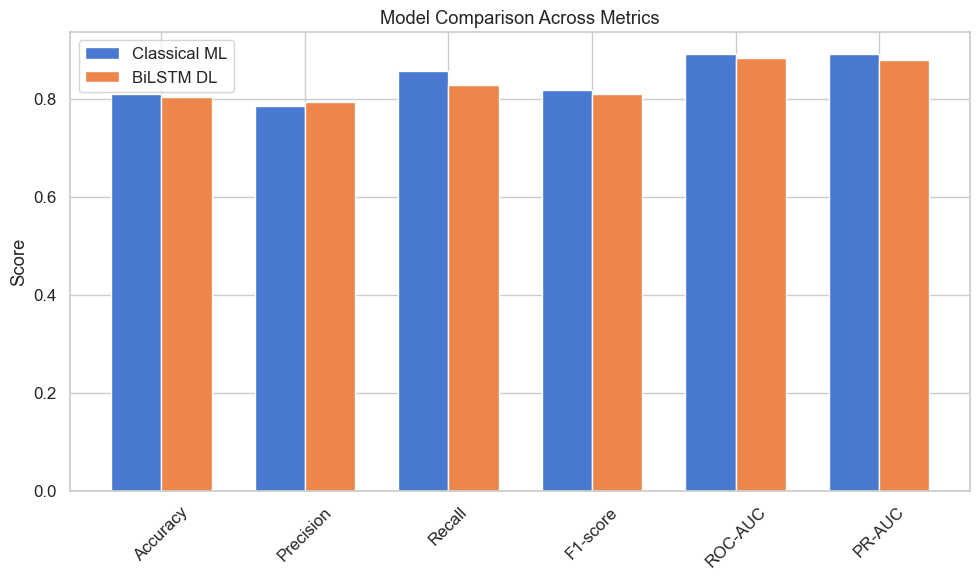

In [14]:
plt.figure(figsize=(10,6))  # Set figure size

bar_width = 0.35  # Width of each bar
x = np.arange(len(df_metrics.columns[1:]))  # Positions on x-axis for metrics (exclude 'Model' column)

# Plot bars for Classical ML metrics (shifted left)
plt.bar(x - bar_width/2, df_metrics.iloc[0,1:], width=bar_width, label="Classical ML")
# Plot bars for BiLSTM DL metrics (shifted right)
plt.bar(x + bar_width/2, df_metrics.iloc[1,1:], width=bar_width, label="BiLSTM DL")

# Set x-axis tick labels as metric names
plt.xticks(x, df_metrics.columns[1:], rotation=45)
plt.ylabel("Score")  # Label y-axis
plt.title("Model Comparison Across Metrics")  # Add title
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout to fit everything
plt.grid(True, axis='y')  # Add horizontal grid lines for easier reading
plt.show()  # Display the plot


## 5.6 Combined ROC Curve

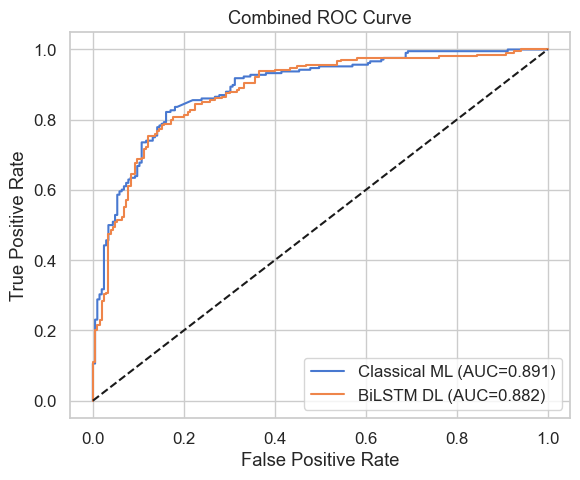

In [15]:
plt.figure(figsize=(6,5))

# Plot ROC curve for Classical ML
plt.plot(fpr_cls, tpr_cls, label=f"Classical ML (AUC={roc_auc_cls:.3f})")
# Plot ROC curve for BiLSTM DL
plt.plot(fpr_dl, tpr_dl, label=f"BiLSTM DL (AUC={roc_auc_dl:.3f})")
# Add diagonal line for random classifier reference
plt.plot([0,1], [0,1], 'k--')

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curve")
plt.grid(True)  # Add grid
plt.legend()  # Show legend
plt.tight_layout()
plt.show()


## 5.7 Combined Precision-Recall Curve

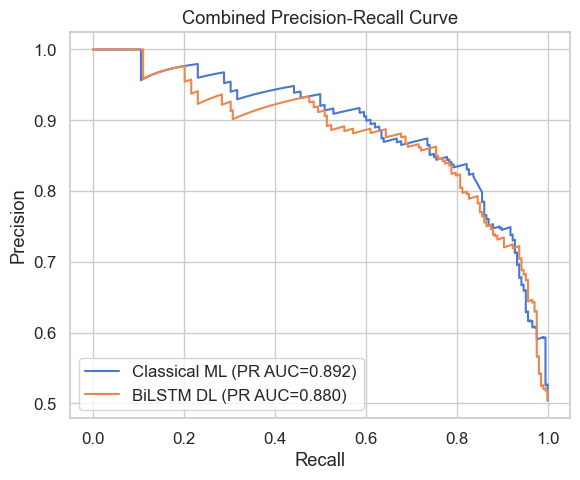

In [16]:
plt.figure(figsize=(6,5))

# Plot Precision-Recall curve for Classical ML
plt.plot(recall_cls, precision_cls, label=f"Classical ML (PR AUC={pr_auc_cls:.3f})")
# Plot Precision-Recall curve for BiLSTM DL
plt.plot(recall_dl_vals, precision_dl_vals, label=f"BiLSTM DL (PR AUC={pr_auc_dl:.3f})")

# Labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Combined Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 5.8 Final Summary

In [17]:
# Print a clear, final comparison table for both models
print("\n=== Final Model Comparison Summary ===")
print(df_metrics.to_string(index=False))

# Determine the best model based on F1-score (balances precision & recall)
best_model_name = df_metrics.loc[df_metrics['F1-score'].idxmax(), 'Model']
print(f"\nBest overall model based on F1-score: **{best_model_name}**")



=== Final Model Comparison Summary ===
       Model  Accuracy  Precision   Recall  F1-score  ROC-AUC   PR-AUC
Classical ML  0.808717   0.784141 0.855769  0.818391 0.891229 0.891547
   BiLSTM DL  0.803874   0.792627 0.826923  0.809412 0.882411 0.879646

Best overall model based on F1-score: **Classical ML**
